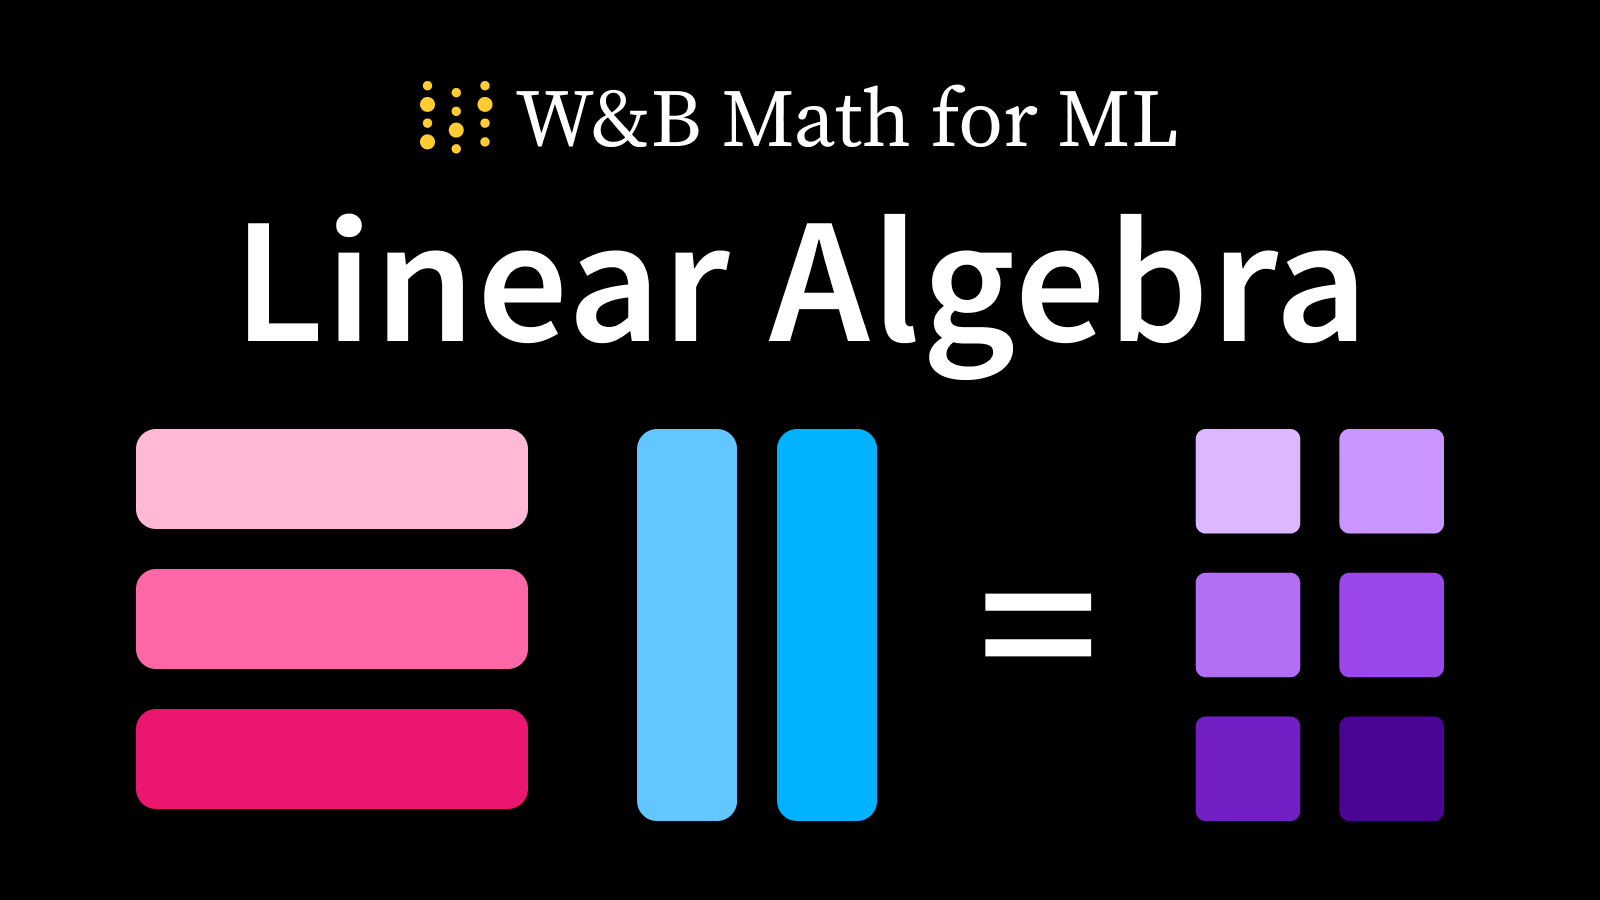

# Extras

## Setup Code

This section includes setup code for the remaining sections.

In [ ]:
%%capture

if "google.colab" in str(get_ipython()):
    %cd "/content/"
    !git clone "https://github.com/wandb/edu.git"
    %cd "edu/math-for-ml"
    !pip install --upgrade -r requirements-colab.txt
    %cd "01_linearalgebra"
else:
    pass

# importing from standard library
import random
import sys

# importing libraries
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.linear_model
import tensorflow as tf
import tensorflow.keras as keras
import torch
import wandb

if "../" not in sys.path:
    sys.path.append("../")

# importing course-specific modules
import utils

# Visualizing Linear Transformations

In two or three dimensions, vectors and linear transformations of vectors
can be easily visualized:
we can draw a bunch of vectors as points on a two-dimensional screen
or in a three-dimensional environment and then _animate_ the transformation.

This section does just that,
with the aim of building intuition for a bunch of concepts from linear algebra:
diagonal matrices, rank, and eigenvectors.

See [this YouTube series by 3blue1brown](https://www.youtube.com/watch?v=F3lG9_SxCXk)
for more visualizations of linear algebraic concepts.

The animations are set up by the `setup_plot` function in the `utils.animate` module.

Run the cell below to see the documentation.

In [ ]:
utils.animate.setup_plot?

## A Collection of Interesting Linear Transformations

This cell defines several linear transformations that you might want to visualize.

You can also define your own linear transformations,
so long as they are represented by two-by-two matrices.

In [ ]:
eye = [[1, 0],
       [0, 1]]

scaling1 = [[3, 0],
            [0, 3]]

scaling2 = [[1/2, 0],
            [0, 1/2]]

shear = [[1, 2],
         [0, 1]]

simple_reflection = [[0, 1],
                     [1, 0]]

negative_reflection = [[0, -1],
                       [-1 ,0]]

rank0 = [[0, 0],
         [0, 0]]

rank1 = [[1, 2],
         [1, 2]]

## Animating the Transformations

This cell creates the animations. See the comments for instructions on use.

Some guiding questions appear below.

In [ ]:
# This line selects the transformation to visualize.
transform = scaling1

# This line places a mesh of points to animate:
#  either centered at 0 or in the top-right quadrant
mesh = utils.animate.all_quadrants_mesh
# mesh = utils.animate.unit_square_mesh

# These lines execute the animation code.

f, ax, animate, n_frames = utils.animate.setup_plot(
    transform,
    mesh_properties=mesh,
    animate_basis=True)

anim = animation.FuncAnimation(f, animate, frames=n_frames)
HTML(anim.to_jshtml(fps=24, default_mode="reflect"))

## Scaling Transformations and Determinants

Visualize the transformations `scaling1` and `scaling2`.

A `scaling` matrix just changes the lengths of vectors, all by the same amount.

#### Q How can we tell a matrix is a scaling matrix just by looking at its entries?

The basis vectors are the columns of an identity matrix (like `eye`).

They determine the bottom and left sides of a square with area 1. We call this the "unit" square.

After the basis vectors are transformed, they still map out a four-sided figure: always a parallelogram, sometimes a rectangle, and sometimes a square.

#### Q What four-sided shape do the basis vectors define when they're transformed by a scaling matrix? Be as specific as possible.

One important property of a matrix is its _determinant_.

Determinants tell us, among other things, the ratio of the area of the parallelogram to the area .

Use the `unit_square_mesh` to visualize this parallelogram directly.

#### Q Based on this geometric information, what's the determinant of a scaling matrix?

There's a very special "scaling" matrix above, called `eye`.

Animate its transformation.

#### Q What's so special about `eye`?

One way of viewing the entries of a matrix is that the columns tell you where your basis vectors go.

#### Q Explain why `eye` is special from this point of view.

Animate the matrices `rank1` and `rank0`.

These matrices have lower _rank_ than the other transformations.

This makes them "non-invertible" -- there is no way to "undo" the transformation they perform.

#### Q Based on the animation, can you explain why?

In the cell below, calculate the determinants of the low-rank matrices (with `np.linalg.det`)

In [ ]:
# apply np.linalg.det here

#### Q What do you get? Give an explanation for this number in terms of the "area of parallelograms" interpretation of the determinant.

## Rotations and Reflections

We call some transformations "reflections" because they act like mirrors --
they transform points on one side of some axis (aka vector) to their mirror images on the other side.

#### What are the axes around which the `negative_reflection` and `simple_reflection` reflect points?

Calling the function `utils.animate.make_rotation` with argument `theta` will make a matrix that rotates the input by an angle `theta`.

This works in radians, not degress, so if you want to make a 90 degree rotation, you should input ${\pi \over 2}$.
In Python, that would be written `np.pi / 2`.

Make a 180 degree rotation matrix, name it `rot180`, and visualize its transformation.

Note that `rot180` and `negative_reflection` both send the `unit_square_mesh` to the bottom-left quadrant.

These transformations are not the same, however.

#### Q Compare the animations. How do the transformations `rot180` and `negative_reflection` differ?

## Combining Matrices

We can combine two transformations into one using matrix multiplication, `np.matmul`.

That is, from two transformations, we produce a single transformation, the _composition_ of the two components.

Compose a rotation matrix and a scaling matrix together and observe the output.

Multiplying two complex numbers, or numbers that can have both real and imaginary parts,
can be implemented using vectors and matrices.

One complex number is represented by a 2-dimensional vector, whose entries represent the real and imaginary components, respectively.

The other is represented by a 2x2 matrix that is the composition of a rotation and a scaling matrix.

The rotation angle $\theta$ and scaling value $r$ for creating this matrix come from the polar representation of the complex number: $r\mathrm{e}^{i\theta}$.

# The Singular Value Decomposition

### Singular Value Decomposition

The _singular value decomposition_ or SVD is used to break a matrix $M$ up
into three canonical components:

- $U$, a "tall" matrix: one that is at least as tall (number of rows) as it is wide (number of columns).
- $S$, a square matrix with zeros everywhere except on the diagonal.
- $V^T$, a "wide" matrix: one that is at least as wide (number of columns) as it is tall (number of rows). It is thought of as the transpose of a matrix $V$.

which are constructed to satisfy the expression below:

$$
U S V^T = M
$$

among some others, which we will shortly investigate.

This decomposition works as follows:

- First, $V^T$ "throws out" every vector that $M$ maps to $0$ (these vectors are the _kernel_ of $M$). The result is that every different output of $V^T$ results in a different output at the end of the pipeline. $V^T$, then, contains all the aspects of $M$ that are "many-to-one". It also performs an orthogonal operation: a composition of rotations and reflections.
- Then, $S$ applies a scaling transformation. It is also often denoted $\Sigma$. It is called the _singular value matrix_ and its entries the <i>singular values</i>. Its inputs are always the same size as its outputs, and it only maps $0$ to $0$. Therefore, it is a square matrix of full rank and so is invertible.
- Finally, $U$ takes the output of $S$ and makes it into an array of the right shape. In general, the output of $S$ can be smaller than the output of $M$, and so $U$ has more rows (i.e. slots in its output) than columns (i.e. slots in its input). $U$ also includes an orthogonal operation.

Let's examine these pieces using the function `utils.svd.compact`.

This specialized version of the SVD was written for this course.
For details on using the version in `numpy`, `np.linalg.svd`,
see the notes at the end of this section.

First, we generate a few matrices to work with: two square matrices with `full_rank` and `low_rank` plus a `wide` and a `tall` matrix.

These matrices are all random: the entries are draw by a random number generator.

In [ ]:
size = 25
rank = 4

full_rank = utils.random_matrix.SymmetricWigner(size).M
low_rank = utils.random_matrix.Wishart(size, rank).M

wide_matrix = np.squeeze(
    [utils.random_matrix.generate_random_unit_vector(dim=size) for _ in range(rank)])
tall_matrix = np.squeeze(
    [utils.random_matrix.generate_random_unit_vector(dim=size) for _ in range(rank)]).T

The utility `utils.svd.show_matrix` is also included, so you can visualize the matrices, as below.

In [ ]:
utils.svd.show_matrix(full_rank); utils.svd.show_matrix(low_rank)

In [ ]:
utils.svd.show_matrix(wide_matrix); utils.svd.show_matrix(tall_matrix)

Next, let's confirm that the SVD is working as intended.

First, we run it,

In [ ]:
U, S, V_T = utils.svd.compact(full_rank)

then, we want to check where $USV^T = M$.

The cell below uses `array_equal`,
which checks whether all of the entries in a pair of arrays are equal.

**Before running this cell below, think about what you expect it to return.**

In [ ]:
np.array_equal(U @ S @ V_T, full_rank)

#### Q Was this surprising?

The definition of the SVD promised equality, but `numpy` is telling us we don't have it.
What gives?

First, computations with floating point numbers are inexact,
and rounding errors abound.
When working with floats, we should be very cautious
about applying any mathematical claims.

And second, the SVD is actually computed using an optimization procedure,
and so the answer is inexact.

So instead of asking whether two arrays are `equal`,
we ask if their entries are `close`:

In [ ]:
np.allclose(U @ S @ V_T, full_rank)

It'd be great if our mathematical results could give us simple tests to run, the way we can define and run tests for other kinds of code, but unfortunately there's typically a large gap between the math in a textbook and what's happening inside our computer.

These sorts of issues make numerical computing, including linear algebra, even harder to learn than other kinds of programming.

Now, let's look at the components of the SVD on some examples.

They are displayed in order, from left to right.

**Low-Rank Matrix**

In [ ]:
utils.svd.show_matrix(low_rank)

In [ ]:
utils.svd.show_svd(*utils.svd.compact(low_rank))

This SVD is a "typical case" for the definition given above.
`V_T` is nice and wide, `S` is much smaller than `M`,
and `U` is very tall.

It is also a typical case for the SVD in practice in ML.
In common uses of the SVD,
the rank is (approximately) very low,
and so the picture above is an accurate mental model.

Compare `U` and `V_T` in the graphic above.
Though within a matrix there is generally no pattern
(because `low_rank` is a random matrix),
you might notice a pattern in the entries
if you look at both simultaneously.
(hint: compare rows of `U` to columns of `V_T`).

The cells below confirm that this pattern holds.

In [ ]:
U_low, S_low, V_T_low = utils.svd.compact(low_rank)

V_low = V_T_low.T

In [ ]:
np.allclose(U_low, V_low)

**Full-Rank Matrix**

When the rank is not low,
the SVD looks rather different.

In [ ]:
utils.svd.show_matrix(full_rank)

In [ ]:
utils.svd.show_svd(U, S, V_T)

Notice that $U$ and $V^T$ are both square.

Review the definition of tall and wide matrices given above,
in the description of the SVD.
Under these definitions, a square matrix is actually both tall and wide!
These kinds of definitional subtleties are typical in mathematics, so watch out.

While for a full-rank square matrix,
$U$ and $V^T$ are both square,
for a low-rank square matrix,
$U$ and $V^T$ are both non-square.

We can also obtain results between these two extremes.

**Wide Matrix**

In [ ]:
utils.svd.show_matrix(wide_matrix)

In [ ]:
utils.svd.show_svd(*utils.svd.compact(wide_matrix))

**Tall Matrix**

In [ ]:
utils.svd.show_matrix(tall_matrix)

In [ ]:
utils.svd.show_svd(*utils.svd.compact(tall_matrix))

For the wide matrix, `V_T` is wide but `U` is square.

The situation is reversed for the tall matrix.

#### On Computing the SVD in `numpy`

When we compute the singular value decomposition, e.g. in `numpy`,
there are a few important things to keep in mind.

First, there are many different "flavors" of SVD, and the flavor implemented by a library might not be the one you're thinking of.

For example, by default, `np.linalg.svd` implements something called a "full" SVD,
in which `U` and `V_T` are square instead of tall and wide.
The same decomposition principle is being applied,
but the details are slightly different.
For example, `U @ S @ V_T` is not directly defined.

If the keyword argument `full_matrices`
is provided to `np.linalg.svd` with the value `False`,
then the flavor of the SVD changes.
Now, it is a form of [reduced SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Reduced_SVDs),
but still not the compact SVD.

Second, `numpy` actually returns a vector of singular values,
which I'll denote `s`,
rather than a matrix of singular values.
For the full SVD,
this means that while `U @ s @ V_T` is undefined,
the expression `U @ np.diag(s) @ V_T` is,
where `np.diag` converts between a vector and
the matrix that has that vectors for its diagonal entries.
`np.diag(s)` is the same as the `S` used above.

In general, there can be a large gap between the algorithms discussed in classes and math textbooks and those implemented in production-grade libraries like `numpy`.
Make sure to read the documentation!

# (almost) Everything is Matrix Multiplication

Almost all of the most important operations in linear algebra are based on matrix multiplication.

The type signature of matrix multiplication appears below,
along with the typical mathematical notation.

$$\mathrm{matmul(x, y)} \colon \mathbb{R}^{n \times m} \times \mathbb{R}^{m \times k} \rightarrow \mathbb{R}^{n \times k}\\
\mathrm{matmul}(x, y) = xy$$

Each section below demonstrates how a key operation in linear algebra is a form of matrix multiplication.

The sections also include implementations in pure Python and in several common data science/machine learning libraries.
Some sections also include examples of where these operations show up in machine learning applications.

### Vector-Vector Operations

#### Dot Product aka Scalar Product aka Inner Product

$$
\mathrm{dot} \colon \mathbb{R}^{n\times 1} \times \mathbb{R}^{n \times 1} \rightarrow \mathbb{R}^{1\times 1}  \\
\mathrm{dot}(x, y) = \sum_i x_i \cdot y_i \\ 
\mathrm{dot}(x, y) = \mathrm{matmul}(x^\top, y)= x^\top y \\ 
\mathrm{dot}(x, y) = \langle x , y \rangle
$$

In [ ]:
N = 3
vector1 = [random.normalvariate(0, 1) for _ in range(N)]
vector2 = [random.normalvariate(0, 1) for _ in range(N)]

##### Pure Python Implementation

In [ ]:
def inner_product(vector1, vector2):
    result = 0
    for element1, element2 in zip(vector1, vector2):
        result += element1 * element2
    return result

##### Numpy Implementations

In [ ]:
def inner_product_numpy(vector1, vector2):
    return np.sum(np.multiply(vector1, vector2))

In [ ]:
def inner_product_numpy_matmul(vector1, vector2):
    vector1 = np.atleast_2d(vector1)
    vector2 = np.atleast_2d(vector2)

    return vector1 @ vector2.T

In [ ]:
def inner_product_numpy_dot(vector1, vector2):
    return np.dot(vector1, vector2)

##### TensorFlow and PyTorch Implementations

In [ ]:
def inner_product_tf(vector1, vector2):
    return tf.reduce_sum(tf.multiply(vector1, vector2)).numpy()

In [ ]:
def inner_product_tf_tensordot(vector1, vector2):
    return tf.tensordot(vector1, vector2, axes=1).numpy()

In [ ]:
def inner_product_torch(vector1, vector2):
    vector1 = torch.Tensor(vector1)
    vector2 = torch.Tensor(vector2)

    return torch.sum(torch.mul(vector1, vector2)).numpy()

##### ML Model Examples: Linear Regression, `keras.Dense`, `torch.nn.Linear`

In [ ]:
def inner_product_sklearn(vector1, vector2):
    regression = sklearn.linear_model.LinearRegression(
      fit_intercept=False)

    regression.coef_ = np.array(vector1)
    regression.intercept_ = 0.

    return regression.predict(np.atleast_2d(vector2))

In [ ]:
def inner_product_keras(vector1, vector2):
    N = len(vector1)
    model = keras.Sequential()
    model.add(
      keras.layers.Dense(
          1, activation=None, use_bias=False, input_shape=(N,),
          kernel_initializer=keras.initializers.Constant(vector1)))

    return model.predict([vector2])

In [ ]:
def inner_product_torchnn(vector1, vector2):
    N = len(vector1)
    layer = torch.nn.Linear(N, 1, bias=False)
    layer.weight = torch.nn.Parameter(torch.Tensor(vector2))

    return layer(torch.Tensor(vector2))

##### ML Calculation Examples: Norms and Cosine Similarity

$\|x\|_2 = \sqrt{\mathrm{dot}(x, x)}$

In [ ]:
def norm(vector):
    return np.sqrt(inner_product(vector, vector))

In [ ]:
def normalize(vector):
    vector_norm = norm(vector)
    return [element / vector_norm for element in vector]

$$\cos(\angle_{x, y}) = \frac{\mathrm{dot}(x, y)}{\|x\|_2\cdot\|y\|_2}$$

In [ ]:
def cosine_similarity(vector1, vector2):
    return inner_product(normalize(vector1), normalize(vector2))

#### Outer Product aka Tensor Product

$$
\mathrm{outer} \colon \mathbb{R}^{n \times 1} \times \mathbb{R}^{n \times 1} \rightarrow \mathbb{R}^{n \times n}  \\
\mathrm{outer}(x, y)_{i, j} = x_i \cdot y_j \\ 
\mathrm{outer}(x, y) = \mathrm{matmul}(x, y^\top) = x y^\top \\
\mathrm{outer}(x, y) = x \otimes y
$$

##### Pure Python Implementation

In [ ]:
def outer_product(vector1, vector2):
    result = []
    for ii, element1 in enumerate(vector1):
        subresult = []
    for jj, element2 in enumerate(vector2):
        subresult.append(element1 * element2)
    result.append(subresult)
    return result

In [ ]:
outer_product(vector1, vector2)

##### Numpy Implementations

In [ ]:
def outer_product_numpy(vector1, vector2):
    return np.outer(vector1, vector2)

In [ ]:
def outer_product_numpy_matmul(vector1, vector2):
    vector1 = np.atleast_2d(vector1)
    vector2 = np.atleast_2d(vector2)

    return vector1.T @ vector2

In [ ]:
outer_product_numpy_matmul(vector1, vector2)

### Matrix-Vector Operations

#### Matrix-Vector Multiplication aka Applying Matrices as Functions

Usually, we think of a matrix as a piece of _data_,
but we can also think of it as a _function_.

When we think of it as a piece of _data_,
we often write it mathematically as a
"member of $\mathbb{R}^{m\times n}$, the set of arrays
with $m$ rows and $n$ columns", like so:

$$X \in \mathbb{R}^{m \times n}$$

As a function, we would write it as "a function that takes in arrays with $n$ entries and returns arrays with $m$ entries", or:

$$X \colon \mathbb{R}^n \rightarrow \mathbb{R}^m$$

It's useful to think of some corner cases:
what if $m == n == 1$?

Then we might have
$$ 2 \in \mathbb{R}$$
or
$$ 2 \colon \mathbb{R} \rightarrow \mathbb{R}$$

where $2(x) = 2x$.

As indicated by this example,
the right notion of what it means to "apply" a matrix as a function
to a vector must be somehow like mutliplication.

In fact, the right method isn't exactly multiplication as we are used to it,
because the inputs and outputs aren't the same shape,
but it's close enough that it goes by the same name:
matrix-vector multiplication.

Its type signature and definition are as follows:

$$\mathrm{matvec}(X, y) \colon \mathbb{R}^{m \times n} \times \mathbb{R}^{n \times 1} \rightarrow \mathbb{R}^{m \times 1}\\
\mathrm{matvec}(X, y) = \mathrm{matmul}(X, y) = Xy$$

$$
\mathrm{matvec}(X, y)_i = \sum_j X_{i,j} y_j\\
\mathrm{matvec}(X, y)_i = {X_{i, \colon}} y
$$

$$
\mathrm{matvec}(X, y) = \sum_j {X_{\colon, j}} y_j
$$

##### Pure Python Implementation

In [ ]:
def matvec(matrix, vector):
    result = []
    for row in matrix:
        result.append(inner_product(row, vector))
    return result

In [ ]:
def matvec_sum(matrix, vector):
    result = []
    for ii, row in enumerate(matrix):
        result_ii = 0
        for jj, element in enumerate(vector):
            result_ii += row[jj] * element 
        result.append(result_ii)
    return result

In [ ]:
M = 3
matrix = [[random.normalvariate(0, 1) for _ in range(N)] for _ in range(M)]

In [ ]:
matvec(matrix, vector1)

In [ ]:
matvec_sum(matrix, vector1)

In [ ]:
np.dot(matrix, vector1)

##### Numpy Implementation

In [ ]:
def matvec_numpy(matrix, vector):
    result = np.zeros_like(np.array(matrix)[:, 0])
    for ii, row in enumerate(matrix):
        result[ii] = np.sum(np.multiply(row, vector))
    return result

In [ ]:
def matvec_numpy_alternate(matrix, vector):
    matrix = np.array(matrix)
    result = np.zeros_like(matrix[:, 0])

    for jj, column in enumerate(matrix.T):
        result += vector[jj] * column
    
    return result

In [ ]:
def matvec_numpy_matmul(matrix, vector):
    return np.array(matrix) @ np.array(vector)

##### Tensorflow and Torch Implementations

In [ ]:
def matvec_tf(matrix, vector):
    return tf.reduce_sum(tf.multiply(matrix, vector), axis=1).numpy()

In [ ]:
def matvec_tf_tensordot(matrix, vector):
    return tf.tensordot(matrix, vector, axes=1).numpy()

Notice that this `tensordot` based implementation is identical to the `inner_product_tf` implementation with `tensordot`. That's because both are just implementing `matmul`!

In [ ]:
def matvec_torch(matrix, vector):
    matrix = torch.Tensor(matrix)
    vector = torch.Tensor(vector)

    return torch.sum(torch.mul(matrix, vector), dim=1).numpy()

##### ML Model Examples: Multiple Linear Regression, `keras.Dense`, `torch.nn.Linear`

Note similarity to dot products above.
Not a coincidence!

In [ ]:
def matvec_sklearn(matrix, vector):
    regression = sklearn.linear_model.LinearRegression(
      fit_intercept=False)

    regression.coef_ = np.array(matrix)
    regression.intercept_ = 0.

    return regression.predict(np.atleast_2d(vector))

In [ ]:
def matvec_keras(matrix, vector):
    N, M = len(matrix), len(matrix[0])
    model = keras.Sequential()
    model.add(
      keras.layers.Dense(
          N, activation=None, use_bias=False, input_shape=(M,),
          kernel_initializer=keras.initializers.Constant(np.array(matrix).T)))

    return model.predict([vector])

Gotcha: `Keras` does all of its matrix multiplications "from the right",
as in $y^\top X$ rather than $Xy$,
so we need to use the transpose here.

In [ ]:
def matvec_torchnn(matrix, vector):
    N, M = len(matrix), len(matrix[0])
    layer = torch.nn.Linear(N, M, bias=False)
    layer.weight = torch.nn.Parameter(torch.Tensor(matrix))

    return layer(torch.Tensor(vector))

### Matrix-Matrix Operations

#### Matrix-Matrix Multiplication aka Composing Matrices as Functions

One of the most important features of functions is that they can be **composed**:
one function can be applied after another, the output of one used as the input of the next.

To compose two functions $f$ and $g$,
where

$$
f\colon A \rightarrow B
$$
and
$$
g\colon B \rightarrow C
$$
we match the output of one to the inputs of the other,
resulting in a new single function,
denoted
$$
g \circ f \colon A \rightarrow C
$$
where
$$
g \circ f(x) = g\left(f(x)\right)
$$

This might be pronounced "$g$ after $f$".

Similarly, when we combine, or compose, two matrices $X$ and $Y$,
the result is a new matrix, $XY$,
which we obtain by multiplying the two matrices:

$$\mathrm{matmul(X, Y)} \colon \mathbb{R}^{n \times m} \times \mathbb{R}^{m \times k} \rightarrow \mathbb{R}^{n \times k}\\
\mathrm{matmul}(X, Y) = XY = X \circ Y$$
$$
\mathrm{matmul}(X, Y)_{ij} = \mathrm{matmul}(X_{i, :}, Y_{:, j})
$$
$$
\mathrm{matmul}(X, Y)_{ij} = \sum_r X_{i, r} Y_{r, j}
$$

In [ ]:
N, M, K = 2, 3, 4
matrix1 = [[random.normalvariate(0, 1) for _ in range(M)] for _ in range(N)]
matrix2 = [[random.normalvariate(0, 1) for _ in range(K)] for _ in range(M)]

##### Pure Python Implementation

In [ ]:
def matmul(matrix1, matrix2):
    result_array = []
    for ii, row in enumerate(matrix1):
        result_row = []
        for jj in range(len(matrix2[0])):
            result = 0
            for kk in range(len(matrix2)):
                result += matrix1[ii][kk] * matrix2[kk][jj]
            result_row.append(result)
        result_array.append(result_row)
    return result_array

In [ ]:
matmul(matrix1, matrix2)

##### Numpy Implementations

In [ ]:
def matmul_numpy(matrix1, matrix2):
    return np.array(matrix1) @ np.array(matrix2)

In [ ]:
def matmul_numpy_dot(matrix1, matrix2):
    return np.dot(matrix1, matrix2)

In [ ]:
def matmul_numpy_matmul(matrix1, matrix2):
    return np.matmul(matrix1, matrix2)

In [ ]:
matmul_numpy(matrix1, matrix2)

In [ ]:
matmul_numpy_dot(matrix1, matrix2)

In [ ]:
matmul_numpy_matmul(matrix1, matrix2)

##### Tensorflow and PyTorch Implementations

In [ ]:
def matmul_tf(matrix1, matrix2):
    return tf.matmul(matrix1, matrix2).numpy()

In [ ]:
def matmul_tf_tensordot(matrix1, matrix2):
    return tf.tensordot(matrix1, matrix2, axes=1).numpy()

In [ ]:
matmul_tf_tensordot(matrix1, matrix2)

In [ ]:
def matmul_torch(matrix1, matrix2):
    matrix1 = torch.Tensor(matrix1)
    matrix2 = torch.Tensor(matrix2)

    return torch.matmul(matrix1, matrix2).numpy()

In [ ]:
def matmul_torch_tensordot(matrix1, matrix2):
    matrix1 = torch.Tensor(matrix1)
    matrix2 = torch.Tensor(matrix2)

    return torch.tensordot(matrix1, matrix2, dims=1).numpy()

In [ ]:
matmul_torch(matrix1, matrix2)

In [ ]:
matmul_torch_tensordot(matrix1, matrix2)